In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import cv2
import os

from torch_snippets import *

import numpy as np

import matplotlib.pyplot as plt

if torch.cuda.is_available():
    devcie = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else: 
    device = "cpu"

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

print("Device: ", device)

C:\Users\olive\miniconda3\envs\torch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device:  cuda

# Hyperparameters

In [2]:
LEARNING_RATE = 1e-3
EPOCHS = 20

# Utilities

In [3]:
def pil2img(image):
    return np.array(image.getdata()).reshape(image.size[1], image.size[0], 3)

def pil2mask(mask):
    return np.array(mask.getdata()).reshape(mask.size[1], mask.size[0], 1)

In [4]:
def expand_mask(mask, channels=3):
    final_mask = np.zeros((channels, 224, 224))
    for channel in range(channels):
        for i in range(mask.shape[1]):
            for j in range(mask.shape[2]):
                if int(mask[0, i, j]) == int(channel):
                    final_mask[channel, i, j] = 1
    return final_mask

# Dataset

In [5]:
class segData(Dataset):
    def __init__(self, split="trainval", n_classes=3):
        self.n_classes = n_classes
        self.ds = torchvision.datasets.OxfordIIITPet(root="data/", split=split,
                                                     target_types="segmentation", download=True)
        
        self.tfms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                             [0.229, 0.224, 0.225])
        ])
        
        
    def __len__(self):
        return self.ds.__len__()
    
    def __getitem__(self, idx):
        image, mask = self.ds.__getitem__(idx)
        image = pil2img(image)
        mask = pil2mask(mask).astype(np.float32)
        image = cv2.resize(image.astype(np.float32), (224,224)).astype(int)
        mask = cv2.resize(mask.astype(np.float32), (224,224)).astype(int)
        return image, mask
        
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([self.tfms(im/255.)[None] for im in ims]).float().to(device)
        masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, masks
        

In [6]:
train_dataset = segData(split="trainval")
val_dataset = segData(split="test")

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=train_dataset.collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, collate_fn=val_dataset.collate_fn)

# Build the Model

In [8]:

def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
     

In [9]:

def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

In [10]:
from torchvision.models import vgg16_bn


In [11]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()
        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x
    
v = vgg16_bn(pretrained=True).to(device)

C:\Users\olive\miniconda3\envs\torch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\olive\miniconda3\envs\torch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

In [13]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

In [14]:
@torch.no_grad()
def validate_batch(mode, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [15]:
model = UNet().to(device)

In [16]:
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training Loop

In [ ]:
log = Report(EPOCHS)
for ex in range(EPOCHS):
    N = len(train_dataset)
    for bx, data, in enumerate(train_dataloader):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex + ((bx+1))/N, trn_loss=loss, trn_acc=acc, end='\r')
    
    N = len(val_dataset)
    for bx, data, in enumerate(val_dataloader):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex + ((bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

EPOCH: 13.229  val_loss: 0.431  val_acc: 0.883  (10484.75s - 5366.15s remaining))

In [ ]:
log.plot_epochs(['trn_loss','val_loss'])

# Visualize

Text(0.5, 1.0, 'Predicted Mask')

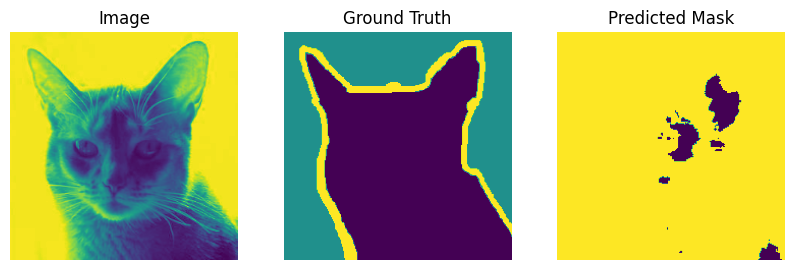

In [25]:
im, mask = val_dataset.__getitem__(4)
mask = torch.tensor(mask)
im = torch.tensor(np.array([im])).permute(0, 3, 1, 2).float().to(device)
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)


# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 1
columns = 3

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(im[0].permute(1, 2, 0).detach().cpu()[:,:,0])
plt.axis('off')
plt.title("Image")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(mask.detach().cpu())
plt.axis('off')
plt.title("Ground Truth")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image

plt.imshow(_mask.detach().cpu().numpy()[0,:,:])
plt.axis('off')
plt.title("Predicted Mask")

In [1]:
criterion(_mask, mask)

NameError: name 'criterion' is not defined

array([1, 2, 3])